## States
- **RED (Stop)**: Recovery phase where arousal decreases, allowing the viewer to rest before resuming stimulation.
- **GREEN (Go)**: Build-up phase where arousal gradually increases, preparing the viewer for higher levels of stimulation.
- **YELLOW (Get to Edge)**: Intense build-up phase that pushes arousal to the edge, preparing the viewer to stay in a highly aroused state.
- **PURPLE (Stay at Edge)**: Peak phase where arousal reaches maximum levels, requiring control to avoid climax and maintain the edge.
- **PINK (Release/End)**: Final state that represents the climax or release, signaling the end of the session.

## State Transitions
- **RED → GREEN**: After a period of recovery, transition to 'GREEN' to begin arousal build-up.
- **GREEN → YELLOW**: When 'Arousal' reaches the current 'Tolerance' level (representing the threshold to reach the edge), transition to 'YELLOW' for intense build-up.
- **YELLOW → PURPLE**: After reaching the edge, transition to 'PURPLE' to hold maximum arousal and stay at the edge.
- **PURPLE → RED**: After maintaining the edge for a specified duration, return to 'RED' for recovery.
- **GREEN → RED**: A random chance allows an unexpected cooldown, returning to 'RED' for brief recovery even if arousal is high.
- **YELLOW_FINAL → PURPLE_FINAL → PINK**: After reaching the climax condition, transition through 'YELLOW_FINAL' and 'PURPLE_FINAL' for the final buildup, ending in 'PINK' (release).

## Internal Variables
1. **Arousal (Pleasure Intensity)**:
   - Represents the viewer's level of stimulation and excitement.
   - Increases during 'GREEN', 'YELLOW', and 'PURPLE' states, with the fastest increase in 'PURPLE' (Stay at Edge).
   - Decreases during 'RED' (Stop) to simulate a cooldown period.
   - Arousal is clamped at 100% during 'PURPLE' to represent the viewer being at the edge of climax.
   - When Arousal reaches the current 'Tolerance' level, the viewer transitions from 'GREEN' to 'YELLOW', signaling the approach to the edge.

2. **Tolerance**:
   - Represents the threshold for climax resistance, increasing the longer the viewer stays in high-arousal states.
   - Starts at 0 and gradually increases in 'YELLOW' and 'PURPLE', allowing the viewer to reach higher arousal levels without climaxing.
   - Higher Tolerance makes it progressively harder to climax, simulating increased control over arousal.
   - In 'YELLOW' and 'PURPLE' states, Tolerance increases, which raises the level of arousal required to transition to the climax state.
   - Maximum Tolerance is capped at 100% to set a limit on the viewer's resistance to climax.
   
3. **Effective Arousal Threshold** (Virtual Line):
   - This is a calculated threshold based on the current Tolerance level.
   - Represents the "achievable arousal" level for the viewer, which needs to be met to trigger certain transitions, such as from 'GREEN' to 'YELLOW'.
   - This line moves higher as Tolerance increases, allowing the viewer to maintain control over higher levels of arousal without reaching climax.

## Summary of Dynamics
- **Arousal** rises in response to 'GREEN', 'YELLOW', and 'PURPLE', with the goal of reaching the current Tolerance level.
- **Tolerance** rises with time spent in 'YELLOW' and 'PURPLE', setting a moving target for Arousal to overcome.
- **Effective Arousal Threshold** (based on Tolerance) creates a dynamic climax threshold, challenging the viewer to resist climaxing at increasingly higher arousal levels.
- Random transitions from **'GREEN' to 'RED'** add variability, preventing predictable cycles and simulating unexpected cooldowns.


the hard-coded purple times should "go back" in time to simulate the greens before them. otherwise you can get scenarios where one edge leads into another
wait maybe i want that? revisit red -> purple logic
have "tolerance" be an end state, as well as number of edges
min edges, min tolerance?
same system as VS: 
    edge: min-max edges
    time: min-max time
    stamina (maybe "her choice?")

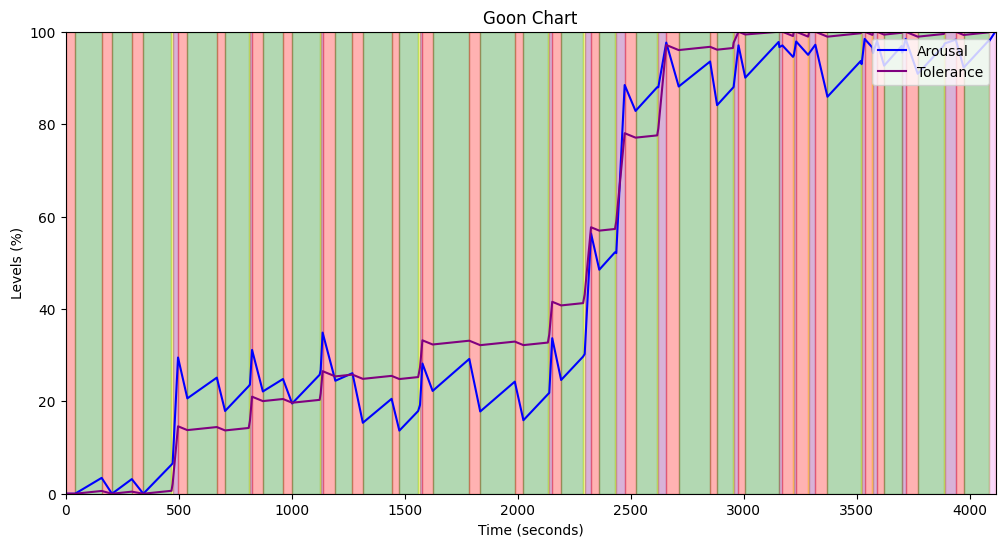

[{'state': 'RED', 'start_time': 0, 'duration': 41.69695375245418},
 {'state': 'GREEN',
  'start_time': 41.69695375245418,
  'duration': 117.52187226744722},
 {'state': 'RED',
  'start_time': 159.2188260199014,
  'duration': 45.809658333284716},
 {'state': 'GREEN',
  'start_time': 205.02848435318612,
  'duration': 87.68312075226959},
 {'state': 'RED',
  'start_time': 292.7116051054557,
  'duration': 50.97388830530135},
 {'state': 'GREEN',
  'start_time': 343.68549341075703,
  'duration': 124.65581071047356},
 {'state': 'YELLOW',
  'start_time': 468.34130412123056,
  'duration': 5.094227252994437},
 {'state': 'PURPLE',
  'start_time': 473.435531374225,
  'duration': 23.88238492416716},
 {'state': 'RED',
  'start_time': 497.31791629839216,
  'duration': 41.20934322357803},
 {'state': 'GREEN',
  'start_time': 538.5272595219702,
  'duration': 130.42343358726458},
 {'state': 'RED',
  'start_time': 668.9506931092349,
  'duration': 36.59793011079028},
 {'state': 'GREEN',
  'start_time': 705.54

In [89]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import random

# Constants
MIN_DURATION = 1000
MAX_DURATION = 4000
MIN_EDGES = 1
MAX_EDGES = 30
GREEN_EDGE_CHANCE_START = 50    # %chance for GREEN -> YELLOW (edge) when tolerance is 0
GREEN_EDGE_CHANCE_END = 80      # %chance for GREEN -> YELLOW (edge) when tolerance is 100
RED_EDGE_CHANCE_START = -50     # %chance for RED -> YELLOW (edge) when tolerance is 0
RED_EDGE_CHANCE_END = 30        # %chance for RED -> YELLOW (edge) when tolerance is 100
MIN_TIME_BEFORE_EDGE = 300  # Minimum time in seconds before transitioning to edge (YELLOW)

AROUSAL_DECAY_RATE = 0.05             # Basic decay rate for arousal
TOLERANCE_DECAY_RATE = 0           # Basic decay rate for tolerance

# RED State (cooldown)
RED_AROUSAL_RATE = -0.05
RED_AROUSAL_STATIC = 0

RED_TOLERANCE_RATE = -0.02
RED_TOLERANCE_STATIC = -0.0

# GREEN State (build-up)
GREEN_AROUSAL_RATE = 0.05
GREEN_AROUSAL_STATIC = 0.5

GREEN_TOLERANCE_RATE = 0.005
GREEN_TOLERANCE_STATIC = 0.01

# YELLOW State (intense edge build-up)
YELLOW_AROUSAL_RATE = 0.2
YELLOW_AROUSAL_STATIC = 0.5

YELLOW_TOLERANCE_RATE = 0.2
YELLOW_TOLERANCE_STATIC = 0.5

# PURPLE State (hold at edge)
PURPLE_AROUSAL_RATE = 1.0
PURPLE_AROUSAL_STATIC = 1.0

PURPLE_TOLERANCE_RATE = 0.5
PURPLE_TOLERANCE_STATIC = 0.5


# State Duration Ranges (in seconds)
STATE_DURATIONS = {
    'RED': (30, 60),
    'GREEN': (60, 180),
    'YELLOW': (5, 10),
    'PURPLE': (10, 50),
    'YELLOW_FINAL': (5, 10),
    'PURPLE_FINAL': (15, 30),
    'PINK': (5, 5)  # Fixed duration
}

# Initial Variables
arousal = 0.0  # Arousal (Pleasure Intensity)
tolerance = 0.0  # Tolerance (Release Threshold), starts at 0

# Scheduled 'PURPLE' times (in seconds)
scheduled_purple_times = []
#scheduled_purple_times = [600, 1200, 1800, 2400, 3000]
scheduled_purple_times.sort()

# Helper Functions
def get_random_duration(state, arousal, tolerance):
    min_duration, max_duration = STATE_DURATIONS[state]
    if state in ['PURPLE', 'PURPLE_FINAL']:
        # Higher tolerance increases duration in 'PURPLE'
        tolerance_factor = max(min(tolerance / 100, 1.0), 0)
        duration = random.uniform(min_duration, max_duration) * (0.5 + 0.5 * tolerance_factor)
    elif state in ['YELLOW', 'YELLOW_FINAL']:
        # Higher tolerance reduces duration in 'YELLOW'
        tolerance_factor = max(min(tolerance / 100, 1.0), 0)
        duration = random.uniform(min_duration, max_duration) * (0.5 + 0.5 * (1 - tolerance_factor))
    else:
        duration = random.uniform(min_duration, max_duration)
    return duration

def sigmoid(x, x0, k):
    return 1 / (1 + np.exp(-k * (x - x0)))

def next_state(current_state, arousal, tolerance, curent_state_duration, total_time):

    next_state = None

    # Check if finish condition is met
    #p = sigmoid(time_elapsed, total_time, 0.01)
    #if random.random() < p or time_elapsed >= MAX_DURATION:

    # Check for scheduled 'PURPLE' state
    if scheduled_purple_times and time_elapsed >= scheduled_purple_times[0]:
        if current_state not in ['PURPLE', 'YELLOW']:
            scheduled_purple_times.pop(0)
            next_state = 'YELLOW'

    # State Transitions
    elif current_state == 'RED':
        edge_chance = RED_EDGE_CHANCE_START + (RED_EDGE_CHANCE_END - RED_EDGE_CHANCE_START) * (tolerance / 100)
        if time_elapsed >= MAX_DURATION:
            next_state = 'YELLOW_FINAL'
        elif time_elapsed <= MIN_TIME_BEFORE_EDGE:
            next_state = 'GREEN'
        elif random.random() > edge_chance / 100:
            next_state = 'GREEN'
        else:
            next_state = 'YELLOW'
    elif current_state == 'GREEN':
        edge_chance = GREEN_EDGE_CHANCE_START + (GREEN_EDGE_CHANCE_END - GREEN_EDGE_CHANCE_START) * (tolerance / 100)
        if time_elapsed >= MAX_DURATION:
            next_state = 'YELLOW_FINAL'
        if time_elapsed <= MIN_TIME_BEFORE_EDGE:
            next_state = 'RED'
        elif random.random() > edge_chance / 100:
            next_state = 'RED'
        else:
            next_state = 'YELLOW'
    elif current_state == 'YELLOW':
        if time_elapsed >= MAX_DURATION:
            next_state = 'PURPLE_FINAL'
        else:
            next_state = 'PURPLE'
    elif current_state == 'PURPLE':
        if time_elapsed >= MAX_DURATION:
            next_state = 'PINK'
        else:
            next_state = 'RED' # TODO: should have some system that goes back to green
    elif current_state == 'YELLOW_FINAL':
        next_state = 'PURPLE_FINAL'
    elif current_state == 'PURPLE_FINAL':
        next_state = 'PINK'
    elif current_state == 'PINK': # End state
        return None, arousal, tolerance, 0
    
    # Update Arousal and Tolerance based on current state
    if current_state == 'RED':
        arousal = min(max(arousal + RED_AROUSAL_RATE * curent_state_duration + RED_AROUSAL_STATIC, 0), 100)
        tolerance = min(max(tolerance + RED_TOLERANCE_RATE * curent_state_duration + RED_TOLERANCE_STATIC, 0), 100)
    elif current_state == 'GREEN':
        arousal = min(max(arousal + GREEN_AROUSAL_RATE * curent_state_duration + GREEN_AROUSAL_STATIC, 0), 100)
        tolerance = min(max(tolerance + GREEN_TOLERANCE_RATE * curent_state_duration + GREEN_TOLERANCE_STATIC, 0), 100)
    elif current_state == 'YELLOW' or current_state == 'YELLOW_FINAL':
        arousal = min(max(arousal + YELLOW_AROUSAL_RATE * curent_state_duration + YELLOW_AROUSAL_STATIC, 0), 100)
        tolerance = min(max(tolerance + YELLOW_TOLERANCE_RATE * curent_state_duration + YELLOW_TOLERANCE_STATIC, 0), 100)        
    elif current_state == 'PURPLE' or current_state == 'PURPLE_FINAL':
        arousal = min(max(arousal + PURPLE_AROUSAL_RATE * curent_state_duration + PURPLE_AROUSAL_STATIC, 0), 100)
        tolerance = min(max(tolerance + PURPLE_TOLERANCE_RATE * curent_state_duration + PURPLE_TOLERANCE_STATIC, 0), 100)
    elif current_state == 'PINK':
        arousal = 0
        tolerance = 0

    duration = get_random_duration(next_state, arousal, tolerance)
    
    #update decay rates
    arousal = min(max(arousal - AROUSAL_DECAY_RATE * duration, 0), 100)
    tolerance = min(max(tolerance - TOLERANCE_DECAY_RATE * duration, 0), 100)
    
    return next_state, arousal, tolerance, duration


# Initialize variables
current_state = 'RED'
timeline = []
emotions = []
time_elapsed = 0

# Initial arousal and tolerance values
arousal = 0.0
tolerance = 0.0

while current_state is not None and time_elapsed < MAX_DURATION*1.2:
    # Set the duration of the current state
    duration = get_random_duration(current_state, arousal, tolerance)

    # Append to timeline and emotions before updating arousal and tolerance
    timeline.append({'state': current_state, 'start_time': time_elapsed, 'duration': duration})
    emotions.append({'time': time_elapsed, 'Arousal': arousal, 'Tolerance': tolerance})
    
    # Update time elapsed
    time_elapsed += duration

    # Get next state and updated variables 
    next_state_name, arousal, tolerance, duration = next_state(current_state, arousal, tolerance, duration, time_elapsed)

    # Transition to next state
    current_state = next_state_name
    
# Define color mapping for states
color_map = {
    'RED': 'red',
    'GREEN': 'green',
    'YELLOW': 'yellow',
    'PURPLE': 'purple',
    'YELLOW_FINAL': 'gold',
    'PURPLE_FINAL': 'violet',
    'PINK': 'pink'
}

# Define times based on emotions' recorded times
times = [e['time'] for e in emotions]

# Visualization of the timeline and internal variables
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the state timeline as background color bars
for segment in timeline:
    color = color_map.get(segment['state'], 'gray')
    start = segment['start_time']
    duration = segment['duration']
    ax1.add_patch(mpatches.Rectangle((start, 0), duration, 100, color=color, alpha=0.3))

# Plot the internal variable levels on top of the timeline
ax1.plot(times, [e['Arousal'] for e in emotions], label='Arousal', color='blue', linewidth=1.5)
ax1.plot(times, [e['Tolerance'] for e in emotions], label='Tolerance', color='purple', linewidth=1.5)


# Add labels and legend
ax1.set_xlim(0, time_elapsed)
ax1.set_ylim(0, 100)
ax1.set_xlabel("Time (seconds)")
ax1.set_ylabel("Levels (%)")
ax1.legend(loc="upper right")
plt.title('Goon Chart')

plt.show()
timeline

In [90]:
emotions

[{'time': 0, 'Arousal': 0.0, 'Tolerance': 0.0},
 {'time': 41.69695375245418, 'Arousal': 0, 'Tolerance': 0.0},
 {'time': 159.2188260199014,
  'Arousal': 3.428529976064299,
  'Tolerance': 0.5976093613372361},
 {'time': 205.02848435318612, 'Arousal': 0, 'Tolerance': 0.0},
 {'time': 292.7116051054557,
  'Arousal': 3.164923303491282,
  'Tolerance': 0.448415603761348},
 {'time': 343.68549341075703, 'Arousal': 0, 'Tolerance': 0.0},
 {'time': 468.34130412123056,
  'Arousal': 6.283737054916838,
  'Tolerance': 0.6332790535523678},
 {'time': 473.435531374225,
  'Arousal': 6.594956848206068,
  'Tolerance': 2.1521245041512556},
 {'time': 497.31791629839216,
  'Arousal': 29.48211142212044,
  'Tolerance': 14.593316966234834},
 {'time': 538.5272595219702,
  'Arousal': 20.640480797894448,
  'Tolerance': 13.769130101763274},
 {'time': 668.9506931092349,
  'Arousal': 25.128705824362168,
  'Tolerance': 14.431247269699597},
 {'time': 705.5486232200251,
  'Arousal': 17.908358647186148,
  'Tolerance': 13.699